In [1]:
# import framework
import pandas as pd
import re
import torch
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- **clean_text(text)**: Converts text to lowercase and removes non-letter characters and extra spaces.
- **build_vocab(texts, max_vocab=20000)**: Creates a vocabulary dictionary mapping the most common words to unique indices; includes special tokens <PAD> and <UNK>.
- **text_to_sequence(text, vocab, max_len=100)**: Converts a text string into a fixed-length sequence of word indices, applying padding or truncation as needed.


In [2]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    return text

def build_vocab(texts, max_vocab=20000):
    counter = Counter()
    for text in texts:
        counter.update(text.split())
    vocab = {word: i+2 for i, (word, _) in enumerate(counter.most_common(max_vocab))}
    vocab["<PAD>"] = 0
    vocab["<UNK>"] = 1
    return vocab

def text_to_sequence(text, vocab):
    return torch.tensor([vocab.get(w, 1) for w in text.split()])

Long Short-Term Memory (LSTM) is a specialized Recurrent Neural Network (RNN) architecture designed to capture long-term dependencies in sequential data. Unlike standard RNNs, which suffer from the vanishing gradient problem, LSTMs use a "cell state" and "gates" to regulate information flow over long periods.

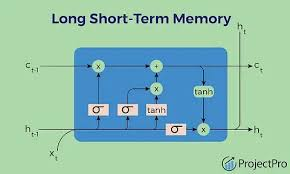

In [4]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, (h, _) = self.lstm(x)
        return self.sigmoid(self.fc(h[-1]))

In [14]:
df = pd.read_csv("/content/sample_data/IMDB Dataset.csv")
df["review"] = df["review"].apply(clean_text)
df["sentiment"] = df["sentiment"].map({"positive":1, "negative":0})

In [15]:
df.head(10)

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production br br the filmin...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically theres a family where a little boy j...,0
4,petter matteis love in the time of money is a ...,1
5,probably my alltime favorite movie a story of ...,1
6,i sure would like to see a resurrection of a u...,1
7,this show was an amazing fresh innovative ide...,0
8,encouraged by the positive comments about this...,0
9,if you like original gut wrenching laughter yo...,1


In [16]:
vocab = build_vocab(df["review"])
sequences = [text_to_sequence(t, vocab) for t in df["review"]]
X = pad_sequence(sequences, batch_first=True)
y = torch.tensor(df["sentiment"].values).float().view(-1,1)

In [17]:
X = X.long()
y = y.float()


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [21]:
model = LSTMClassifier(len(vocab)).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

dataset = TensorDataset(X_train, y_train)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [22]:
for epoch in range(5):
    total_loss = 0
    model.train()

    for batch_x, batch_y in loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)

        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(loader):.4f}")

Epoch 1, Loss: 0.6937
Epoch 2, Loss: 0.6935
Epoch 3, Loss: 0.6934
Epoch 4, Loss: 0.6933
Epoch 5, Loss: 0.6934


Prediction Model

In [23]:
model.eval()
with torch.no_grad():
    sample = X[0].unsqueeze(0).to(device)
    pred = model(sample)
    print("Prediction:", "Positive" if pred.item() > 0.5 else "Negative")

Prediction: Negative


saveing model

In [24]:
torch.save(model.state_dict(), "lstm_model.pth")